In [1]:
import pandas as pd
import numpy as np
import itertools
import math
import os

from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
    from tensorflow.keras.optimizers import SGD
except:
    os.system('python3 -m pip install tensorflow==2.7')
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
    from tensorflow.keras.optimizers import SGD

# Artificial Neural Networks applied in Football Analytics III

During my project, I built different kinds of Artificial Neural Network (ANN) models in order to solve some problems and see new applications of data in sports analytics. To do so, I used TensorFlow, an open-source library for machine learning that is very optimised for this kind of models. I chose this library as it is one of the most popular ones.

As I started working with TensorFlow, I encountered a few backward-compatibility issues due to newer versions of the library not being able to run code written for older versions. Therefore, I made sure to use the same version of TensorFlow as the one used to prepare this project: 2.7 (latest stable version at the moment of writing this).

During the project, I built 3 different kinds of ANN, each to solve a different problem using a different dataset. I started by designing and training a Multilayer Perceptron (MLP) (or feedforward ANN) to compute a metric called Post-Shot Expected Goals (PSxG). Later on, I constructed a Convolutional Neural Network (CNN) to be used as an action selection model through spatial data. Finally, I designed an Autoencoder to reduce the dimensionality of a dataset consisting of aggregated player stats in order to apply clustering algorithms and find different groups of players, which is the focus of this Notebook.

It is worth noting that ANNs allow for lots of hyper-parameters to be tuned, as well as the many possible structures we can use. Finding the most appropriate design is sometimes regarded more as an art rather than a science, given that trying all possible combinations may be too power and time consuming. Due to the time limitation of my project, I only tried to find performance improvements by applying some tweaks on the model for the first exercise. For the rest, I focused on how can the different network structures be helpful given their nature. I didn't use methods such as cross-validation for model selection due to time limitations, but I am aware that these procedures should be used when dealing with real-world problems.

The next cell presents a group of methods that I will use to train and evaluate the NN models I create. This will be helpful to allow changing model parameters and configurations in a simplified manner. The methods are pretty straight-forward.

In [2]:
def train_and_evaluate_model(m, _data, loss="mean_squared_error", metrics=["accuracy", "mean_squared_error"], learning_rate=0.1, momentum=0.0, epochs=50, batch_size=64, verbose=1):
    evaluate_model(train_model(m, _data, loss, metrics, learning_rate, momentum, epochs, batch_size, verbose), _data, metrics)

def train_model(m, _data, loss="mean_squared_error", metrics=["accuracy", "mean_squared_error"], learning_rate=0.1, momentum=0.0, epochs=50, batch_size=64, verbose=1):
    tf.random.set_seed(1234)
    m.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss=loss, metrics=metrics)
    m.fit(_data["X_train"], _data["y_train"], epochs=epochs , batch_size=batch_size, validation_split=0.2, verbose=verbose)
    return m

def evaluate_model(m, _data, metrics):
    r = m.evaluate(_data["X_test"], _data["y_test"], verbose=0)
    print("\n" + " | ".join("{0}: {1}".format(metric, value) for metric, value in zip(metrics, r[1:])))

## 3. Player Clustering with Autoencoders

The final type of ANN I built was an autoencoder. Autoencoders are a special kind of feed-forward NN whose main characteristic is that they try to predict the original values fed to the model. Their structure is normally divided into two parts: the encoder and the decoder. They tend to be symmetrical networks when cut from the middle, as seen in the diagram in the following cell.

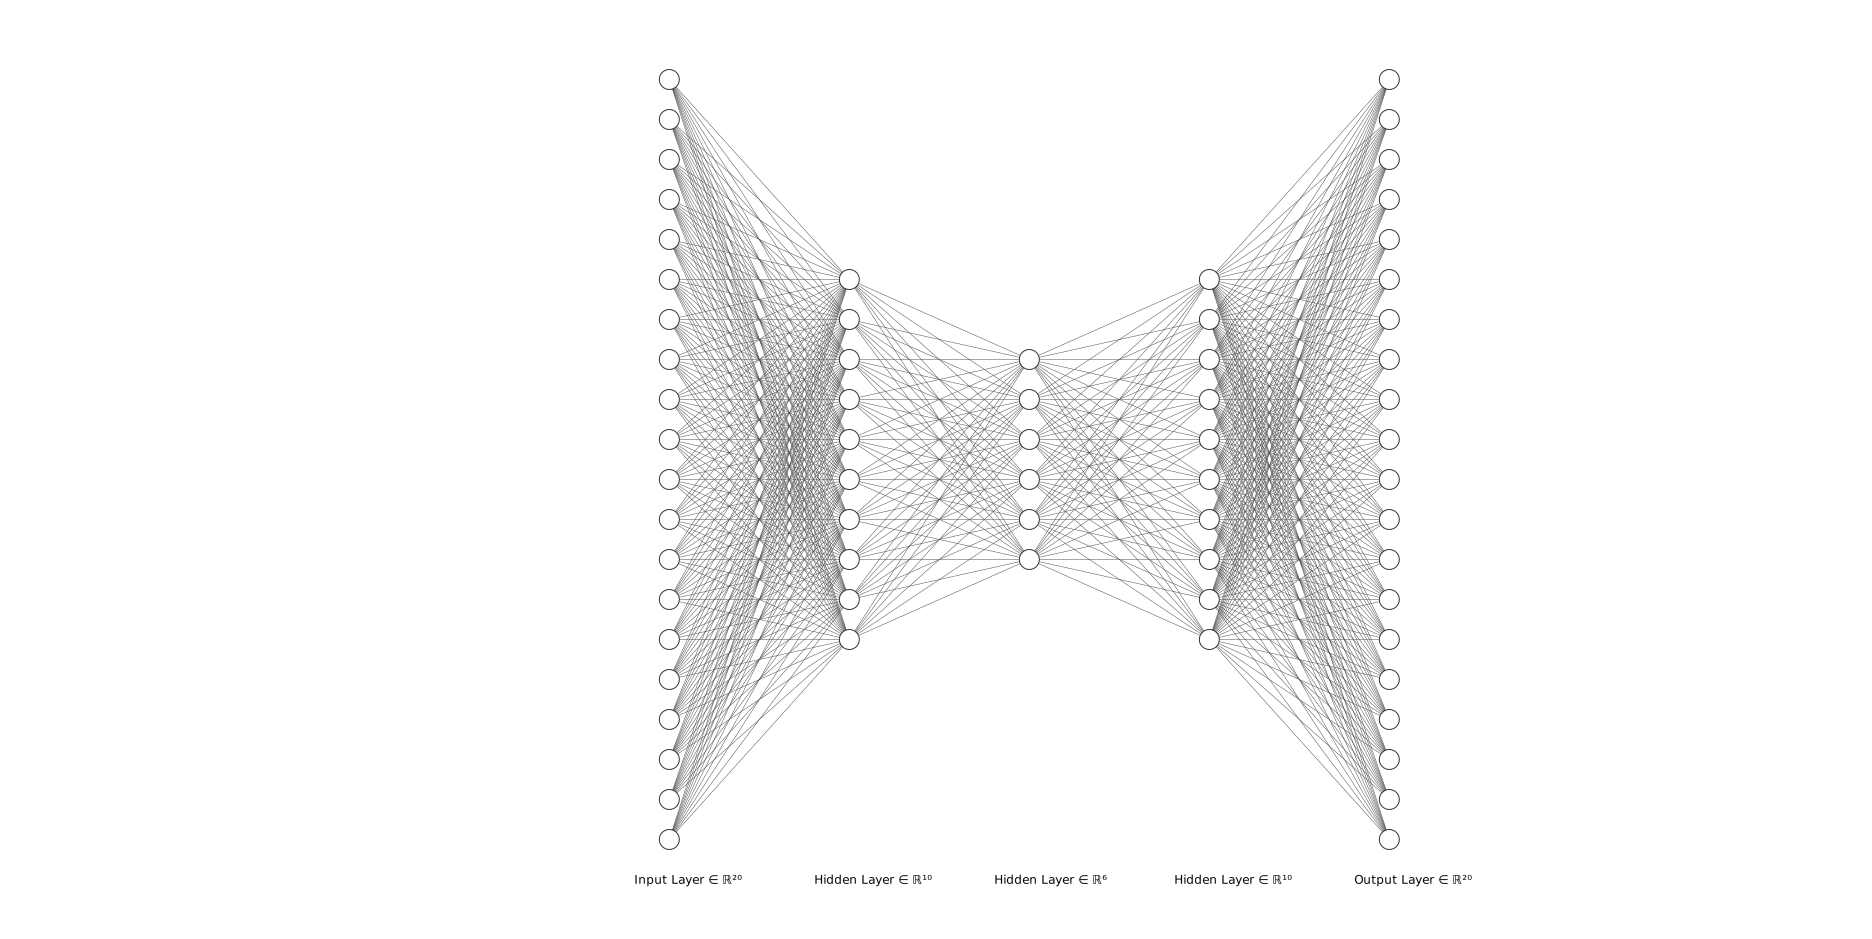

In [3]:
from IPython.core.display import SVG
SVG(filename='assets/autoencoder.svg')

Autoencoders are very useful because, if they are correctly trained to make good recreations of the original data, they serve as a process to reduce the dimensionality of the data. This is because if we just use the encoder part of the network, all the high-dimensional data passed through it is converted to a lower dimensionality, while maximizing the information contained. The new dimensionality is determined by the number of neurons established for the hidden layer in the middle, known as the latent dimensions.

I used player stats data to train an autoencoder. Then, I used its encoder to perform dimensionality reduction on the original data and perform clustering using fewer variables but with maximized variability.

In [4]:
df_player_stats = pd.read_csv("data/df_player_stats.csv")
df_player_stats.head()

,player_name,team_name,match_id,aerials_abp,aerials_offensive_successful,aerials_defensive_successful,assists,assists_cross,assists_xg,attacks_mins_for,...,recoveries_oppfield,shots,shot_xg_foot,shot_xg_head,shots_corner,shots_cross,shots_direct_freekick,shots_rebound,tackles_ownfield,tackles_oppfield
0,Player 708,Team 98,Match 967,0.0,0.0,1.0,1.0,0.0,0.194937,32.243367,...,9.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,Player 1966,Team 92,Match 2103,2.0,0.0,1.0,0.0,0.0,0.000000,27.612383,...,2.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Player 2049,Team 11,Match 751,2.0,0.0,0.0,1.0,0.0,0.044316,28.167450,...,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,Player 791,Team 103,Match 2278,0.0,1.0,0.0,0.0,0.0,0.000000,25.968183,...,5.0,1.0,0.08114,0.0,0.0,0.0,0.0,0.0,4.0,2.0
4,Player 844,Team 20,Match 1932,0.0,0.0,0.0,2.0,1.0,0.315262,11.793767,...,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Given the provided player data, I began by discerning the offensive variables from the defensive ones and disregarded those that I thought would not be useful. Then, I aggregated this data per player in a team. To ensure that the final aggregated variables were normalised per effective time, I normalised the offensive ones per 30 minutes of effective time with the ball (attacks_mins_for) and the defensive ones per 30 minutes of effective time without the ball (attacks_mins_against).

As a final consideration, I only kept those players who had played more than an aggregated amount of 450 minutes (mins_played) in order to avoid possible outliers with players who had played few games.

In [5]:
offensive_vars = ['aerials_offensive_successful','assists','assists_cross','assists_xg','crosses','crosses_goal', 
                  'crosses_received', 'crosses_shot', 'dribbles_ownfield','dribbles_oppfield', 'drives_offensive', 
                  'drives_offensive_box','goals','lost_balls_oppfield','passes_box_successful','passes_long',
                  'passes_long_successful', 'passes_second_or_third_assist','passes_through_ball','shots', 'attacks_mins_for',]

defensive_vars = ['aerials_defensive_successful','fouls_ownfield', 'fouls_oppfield','interceptions_oppfield', 
                  'interceptions_ownfield','recoveries_ownfield', 'recoveries_oppfield','tackles_ownfield','tackles_oppfield',
                  'attacks_mins_against',]

not_used_vars = ['aerials_abp', 'mins_played','shot_xg_foot', 'shot_xg_head', 'shots_corner', 
                 'shots_cross','shots_direct_freekick', 'shots_rebound','lost_balls_ownfield',]


# We discard players who did not play at leaast 450 min
df_players = df_player_stats.groupby(['player_name','team_name']).sum()
df_players = df_players[df_players['mins_played']>450]

# We normalise by effective game time
df_players_off = df_players[offensive_vars]
df_players_off = df_players_off.apply(lambda row: row/(row.attacks_mins_for/30),axis=1).drop('attacks_mins_for',axis=1)

df_players_def = df_players[defensive_vars]
df_players_def = df_players_def.apply(lambda row: row/(row.attacks_mins_against/30),axis=1).drop('attacks_mins_against',axis=1)

# We merge again off and def vars
df_players = pd.merge(df_players_off, df_players_def, left_index=True, right_index=True)
df_players

aerials_offensive_successful   assists  assists_cross  \
player_name team_name                                                          
Player 10   Team 65                        0.000000  1.583821       0.296966   
Player 100  Team 34                        0.050632  0.050632       0.000000   
            Team 85                        0.030081  0.120323       0.000000   
Player 1002 Team 109                       1.041244  0.644580       0.297498   
Player 1003 Team 58                        1.766738  0.210954       0.026369   
...                                             ...       ...            ...   
Player 995  Team 25                        0.000000  0.017493       0.000000   
Player 996  Team 56                        0.425662  1.915480       0.000000   
Player 997  Team 76                        4.527602  0.798989       0.121059   
Player 998  Team 49                        1.050609  0.450261       0.300174   
Player 999  Team 59                        0.734010  1.468021       0.660609   

                       assists_xg   crosses  crosses_goal  crosses_received  \
player_name team_name                                                         
Player 10   Team 65      0.184429  1.930282      0.049494          0.445450   
Player 100  Team 34      0.005509  0.000000      0.000000          0.000000   
            Team 85      0.004142  0.000000      0.000000          0.000000   
Player 1002 Team 109     0.073376  1.685824      0.000000          0.297498   
Player 1003 Team 58      0.028080  0.184585      0.000000          0.079108   
...                           ...       ...           ...               ...   
Player 995  Team 25      0.000803  0.000000      0.000000          0.000000   
Player 996  Team 56      0.125409  1.064156      0.000000          0.212831   
Player 997  Team 76      0.069659  0.411600      0.024212          0.193694   
Player 998  Team 49      0.079602  0.750435      0.000000          0.300174   
Player 999  Team 59      0.308820  3.743453      0.000000          1.394620   

                       crosses_shot  dribbles_ownfield  dribbles_oppfield  \
player_name team_name                                                       
Player 10   Team 65        0.247472           0.940394           2.969665   
Player 100  Team 34        0.000000           0.000000           0.000000   
            Team 85        0.000000           0.030081           0.000000   
Player 1002 Team 109       0.297498           0.446248           0.644580   
Player 1003 Team 58        0.026369           0.421908           0.237323   
...                             ...                ...                ...   
Player 995  Team 25        0.000000           0.017493           0.000000   
Player 996  Team 56        0.000000           0.212831           0.212831   
Player 997  Team 76        0.145271           0.193694           0.508447   
Player 998  Team 49        0.300174           0.450261           0.450261   
Player 999  Team 59        0.734010           0.146802           0.734010   

                       ...     shots  aerials_defensive_successful  \
player_name team_name  ...                                           
Player 10   Team 65    ...  0.890899                      0.061133   
Player 100  Team 34    ...  0.000000                      0.000000   
            Team 85    ...  0.060162                      0.000000   
Player 1002 Team 109   ...  0.297498                      0.947062   
Player 1003 Team 58    ...  0.474646                      2.242659   
...                    ...       ...                           ...   
Player 995  Team 25    ...  0.000000                      0.000000   
Player 996  Team 56    ...  0.638493                      0.000000   
Player 997  Team 76    ...  0.968471                      1.105669   
Player 998  Team 49    ...  0.150087                      3.746452   
Player 999  Team 59    ...  0.146802                      0.759004   

                       fouls_ownfield  fo

I decided to not select some of the least useful (in my opinion) offensive variables, to try to balance a bit between offensive and defensive variables, and some variables I did not find useful anyways. In the end there are 29 variables we are looking into.

Keeping only the features I have dimmed relevant, I will proceed to train the autoencoder. First, though, I had to prepare the data as always. Note though that this time I did not need the y subsets. The response variables are the same as the predictor ones.

In [6]:
X = df_players
train_index, test_index = list(ShuffleSplit(n_splits=1, test_size=0.33, random_state=1234).split(X))[0]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
data = {"X_train": scaler.transform(X_train), "y_train": scaler.transform(X_train), "X_test": scaler.transform(X_test), "y_test": scaler.transform(X_test)}

The following class built a NN similar to the one seen in the previous diagram. The structure was similar to the MLP's structure, but this time I stored each half of the network into a different variable. This way I could use them either together or separately. The output layer had the same amount of neurons as the input size, and I fixed the size of the hidden layers that did not contain the latent dimensions to be half of the input size. All I had to do was decide the number of latent dimensions I wanted to find.

In [8]:
class Autoencoder(Model):
    def __init__(self, input_size, latent_dim):
        super(Autoencoder, self).__init__()
        hidden_layer_size = int(input_size/2)
        self.encoder = tf.keras.Sequential([
            Dense(hidden_layer_size, activation='relu'),
            Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            Dense(hidden_layer_size, activation='relu'),
            Dense(input_size, activation='relu'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# for i in range(1,26):
#     print(i)
#     autoencoder = Autoencoder(X.shape[1], i)
#     train_and_evaluate_model(autoencoder, data, metrics=["mean_squared_error"], epochs=100, batch_size=32, momentum=0.9,verbose=0)

I tried different values and decided to select 8, because it keeps a similar structure than the provided example from 20,10,6. In this case it is 30, 15, 8, and it keeps a higher value for RMSE, than with other combinations.

And now we are ready to fit the autoencoder...

In [9]:
autoencoder = Autoencoder(X.shape[1], 8)
train_and_evaluate_model(autoencoder, data, metrics=["mean_squared_error"], epochs=100, batch_size=32, momentum=0.9)

Epoch 1/100
49/49 [==============================] - 2s 13ms/step - loss: 0.9220 - mean_squared_error: 0.9220 - val_loss: 0.9385 - val_mean_squared_error: 0.9385
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.8500 - mean_squared_error: 0.8500 - val_loss: 0.9070 - val_mean_squared_error: 0.9070
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 0.8204 - mean_squared_error: 0.8204 - val_loss: 0.8756 - val_mean_squared_error: 0.8756
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.7928 - mean_squared_error: 0.7928 - val_loss: 0.8358 - val_mean_squared_error: 0.8358
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.7610 - mean_squared_error: 0.7610 - val_loss: 0.8041 - val_mean_squared_error: 0.8041
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 0.7344 - mean_squared_error: 0.7344 - val_loss: 0.7733 - val_mean_squared_error: 0.7733
Epoch 7/100
49/49 [==============

Now to obtain the latent values of the players in the dataset will be as easy as to...

In [10]:
player_values = autoencoder.encoder(scaler.transform(X)).numpy()

With the player values I have just have obtained, I performed a hierarchical clustering and described briefly the clusters I found.

Text(0, 0.5, 'Distance')

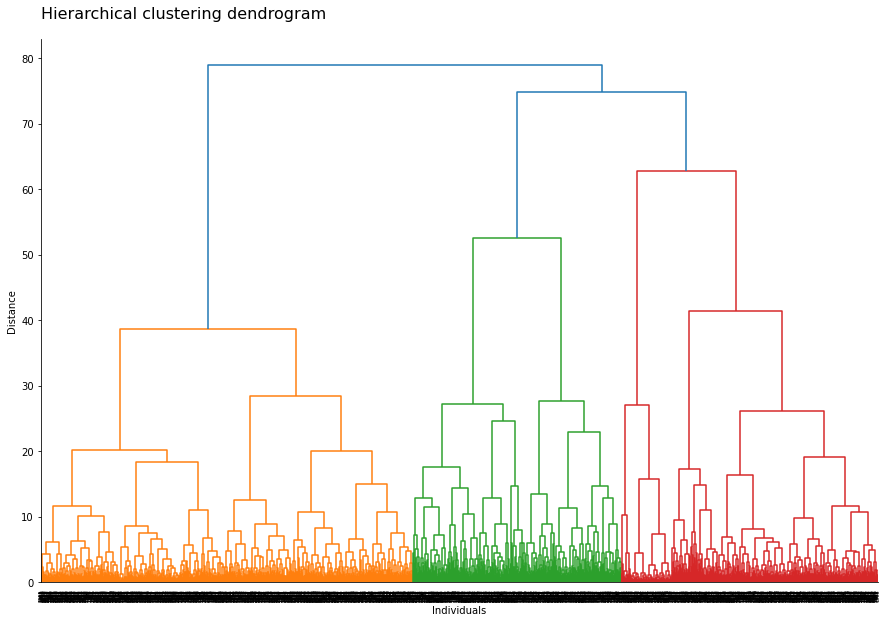

In [11]:
from scipy.cluster import hierarchy

fig, ax = plt.subplots(figsize=(15, 10))

# Computing the distances among the individuals
distances = hierarchy.distance.pdist(player_values)

# Computing the linkage matrix
linkage_matrix = hierarchy.linkage(distances, 'ward')

# Plotting the dendrogram to decide the number of clusters
dendrogram = hierarchy.dendrogram(linkage_matrix, ax=ax, color_threshold=70)

# Title setting
ax.set_title("Hierarchical clustering dendrogram", loc="left", pad=20, fontsize=16)

# Axes configuration
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Individuals")
ax.set_ylabel("Distance")

In [12]:
clustering = hierarchy.cut_tree(linkage_matrix, n_clusters=3)
clustering = clustering+1

In [13]:
# I modified the function to show in a clearer way for me to explain the results
def get_cluster_stats(cluster_rows):
    return cluster_rows.groupby('cluster').mean().T.join(
        cluster_rows.drop(columns=["cluster"]).mean().to_frame("Overall mean")).join(
        cluster_rows.groupby('cluster').std().T,lsuffix='_mean',rsuffix='_std').join(
        cluster_rows.drop(columns=["cluster"]).std().to_frame("Overall std")
    ).fillna(0)

In [14]:
df_players['cluster'] = clustering
get_cluster_stats(df_players)

,1_mean,2_mean,3_mean,Overall mean,1_std,2_std,3_std,Overall std
aerials_offensive_successful,1.311914,0.781042,0.635976,0.981025,1.507476,0.615961,0.535822,1.135040
assists,0.944424,0.297720,1.373468,0.853044,0.453279,0.330984,0.731139,0.650724
assists_cross,0.162398,0.081433,0.258171,0.161424,0.152089,0.143287,0.268804,0.197038
assists_xg,0.101663,0.036502,0.174426,0.099805,0.063286,0.050982,0.117637,0.092912
crosses,1.188093,0.596292,1.633359,1.117573,0.936675,0.959399,1.362417,1.133590
crosses_goal,0.024344,0.009932,0.041133,0.024106,0.040658,0.026972,0.067861,0.047289
crosses_received,0.333579,0.162810,0.501194,0.322968,0.281528,0.272196,0.452711,0.353114
crosses_shot,0.150207,0.072959,0.241830,0.149340,0.145771,0.130581,0.249589,0.184586
dribbles_ownfield,0.618293,0.307043,0.650846,0.531024,0.424125,0.335013,0.438619,0.429527
dribbles_oppfield,1.529663,0.387283,1.644615,1.208232,1.046777,0.618050,1.335595,1.160804


* Cluster 1

['aerials_offensive_successful', 'assists', 'assists_cross',
       'assists_xg', 'crosses', 'crosses_goal', 'crosses_received',
       'crosses_shot', 'dribbles_ownfield', 'dribbles_oppfield',
       'drives_offensive_box', 'goals', 'lost_balls_oppfield',
       'passes_second_or_third_assist', 'passes_through_ball', 'shots',
       'fouls_oppfield', 'recoveries_oppfield']
       
* Cluster 2

['drives_offensive', 'passes_long', 'passes_long_successful',
       'aerials_defensive_successful', 'interceptions_ownfield',
       'recoveries_ownfield', 'tackles_ownfield']
       
* Cluster 3

['assists', 'assists_cross', 'assists_xg', 'crosses', 'crosses_goal',
       'crosses_received', 'crosses_shot', 'dribbles_ownfield',
       'dribbles_oppfield', 'drives_offensive', 'drives_offensive_box',
       'goals', 'lost_balls_oppfield', 'passes_box_successful',
       'passes_long_successful', 'passes_second_or_third_assist',
       'passes_through_ball', 'shots', 'fouls_ownfield', 'fouls_oppfield',
       'interceptions_oppfield', 'interceptions_ownfield',
       'recoveries_ownfield', 'recoveries_oppfield', 'tackles_ownfield',
       'tackles_oppfield']
       
       
Above we can see the variables where each cluster is above the average. As we can see C3 is the one that tends to have most of the variables over the mean, but if we look at the std we can see it also always tend to be higher. This makes sense because if we were to split in 4 clusters instead of 3, the one split would have been C3. Then, C1 is also quite overall over the mean while C2 tens to be mostly under the average in most statistics, while having normally the least amount of standard deviation.

C2 may be a defensive type of players as they are over the mean in ownfield interceptions, recoveries and tackles, and also in successful defensive aerials. Also playing part into the counter attacking with offensive drives, and long passes both tried and successful, probably to the attacking players

C1 looks more attacking players overall as it stands out in quite some offensive variables, while only shining in 2 of the defensive vars, which are also on the opponent field, showing a high pressure after losing the ball probably. This goes together with losing more balls in the opponents fields. Overall their values tend to be smaller than those of the C3 teams but higher than C2 teams by quite a lot in some cases. It is the highest values in goals and shots, again proving they are the attacking players.

C3 is over the mean in all of the variables except for long passes and both offensive and defensive aerial duels. This are most probably midfielder players, having the best values for most cases in both defensive and offensive statistics. Also it makes sense since they also have higher values for lost balls, which is normally the case for midfielders. Moreover, as seen above the cluster tends to have a higher std because there is quite a lot of difference between attacking midfielders and defensive ones for example, and this is why if we were to split with 4 clusters, they would have been divided.